In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from argparse import ArgumentParser
import itertools
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline
# ## Initialize Model
from rnn_lib import utils
from rnn_lib.base_rnn import RNNCell
from rnn_lib.model import Model
from rnn_lib.dense_layers import DenseLayer
from rnn_lib.init_policies import W_TorchInit, U_TorchInit

#### song
from rnn_lib.dense_layers import ColumnEiDense
from rnn_lib.song_rnn import ColumnEiCell
from rnn_lib.init_policies import ColumnEi_FirstCell_U_InitPolicy, ColumnEiCell_W_InitPolicy
from rnn_lib.update_policies import ColumnEiSGD_Clip, ColumnEiDenseSGD

#### danns
from rnn_lib.dense_layers import EiDense
from rnn_lib.dann_rnn import EiRNNCell
from rnn_lib.init_policies import EiDenseWeightInit_WexMean, EiRNNCell_W_InitPolicy
from rnn_lib.update_policies import EiRNN_cSGD_UpdatePolicy2, DalesANN_cSGD_UpdatePolicy2
from src.bandit import dependent_bandit

In [ ]:
bandit_difficulty = 'easy'
PLAYGROUND_DIR = f"~/logs/EI_RLDM/bandit/{bandit_difficulty}"

In [4]:
# ## Set Hyperparameters
input_features = 4
n_actions = 2
n_hidden = 48
device = 'cpu'
test_interval = 1
model_type = "rnn"
n_seeds = 1
seeds = [i for i in range(n_seeds)]
grad_clip_list = [1]
rad_list = [1]
lr_list = [6e-4]
lr_list = [round(learning_rate, 6) for learning_rate in lr_list]
ei_ratio_list = [4]

para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list)) # 
(seed, learning_rate, grad_clip, rad, ei_ratio) = para_comb[0]

In [5]:
# Initialize Bandit Environments
batch_size = 256  # Batch of bandit environments
bandits = [dependent_bandit(difficulty=bandit_difficulty) for _ in range(batch_size)]
test_batch_size = 10
num_batches = 1 
num_episodes = 600
num_trials_per_ep = 100
test_num_trials = 100

discount = 0.8

In [6]:
# Softmax Policy Function
def select_action(logits):
    probabilities = F.softmax(logits, dim=-1)
    action_distribution = torch.distributions.Categorical(probabilities)
    action = action_distribution.sample()
    return action, action_distribution.log_prob(action)

In [7]:
# ## Initialize Model
# Set model type ('rnn' for vanilla RNN, 'colei' for Song et al. model)
if model_type == "rnn":
    cells = [RNNCell(input_features, n_hidden, nonlinearity=F.relu, i2h_init_policy=U_TorchInit(), h2h_init_policy=W_TorchInit()),
             DenseLayer(n_hidden, n_actions, nonlinearity=None)]
elif model_type == "colei":
    pixel_mean = 0#(data_train * masks_train[..., np.newaxis]).mean()
    cells = [ColumnEiCell(input_features, (n_hidden, ei_ratio),
                          nonlinearity=F.relu, 
                          i2h_init_policy=ColumnEi_FirstCell_U_InitPolicy(pixel_mean=pixel_mean), 
                          h2h_init_policy=ColumnEiCell_W_InitPolicy(radius=rad), 
                          update_policy=ColumnEiSGD_Clip(max=grad_clip)),
             ColumnEiDense(n_hidden, (n_actions, ei_ratio),
                           nonlinearity=None, update_policy=ColumnEiDenseSGD(max=grad_clip))
            ]
elif model_type == "danns":
    cells = [EiRNNCell(input_features, n_hidden, max(n_hidden//(ei_ratio+1), 1), max(n_hidden//(ei_ratio+1), 1),
                       nonlinearity=F.relu,
                       h2h_init_policy=EiRNNCell_W_InitPolicy(numerator=1/3, random=False)),
            EiDense(n_hidden, n_actions, max(n_actions//(ei_ratio+1),1),
                     nonlinearity=None, 
                     weight_init_policy=EiDenseWeightInit_WexMean(numerator=2))
            ]
    for cell in cells[-1:]:
        cell.update_policy = DalesANN_cSGD_UpdatePolicy2(max_grad_norm=grad_clip)
    for cell in cells[:-1]:
        cell.update_policy = EiRNN_cSGD_UpdatePolicy2(max_grad_norm=grad_clip)
else:
    raise ValueError("Invalid model type")

model = Model(cells)
model.init_weights()
model.reset_hidden(batch_size=batch_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
params = utils.Params()
# Set model type ('rnn' for vanilla RNN, 'colei' for Song et al. model)
params.model_type = model_type
params.grad_clip = grad_clip
params.ei_ratio = ei_ratio
params.rad = rad
params.seed = seed
params.batch_size = batch_size
params.num_episodes = num_episodes
params.lr  = learning_rate
params.n_hidden = n_hidden
params.results_dir = f"{PLAYGROUND_DIR}/saved_results"

utils.set_seed_all(params.seed)
params.write_to_config_yaml()

In [9]:
def anneal_entropy_coef(start_coef, end_coef, current_step, total_steps):
    return start_coef - (start_coef - end_coef) * (current_step / total_steps)

In [10]:
def exp_avg_convolve(arr, alpha):
    kernel = (1 - alpha) ** np.arange(len(arr))
    kernel /= kernel.sum()
    return np.convolve(arr, kernel, mode='full')[:len(arr)]

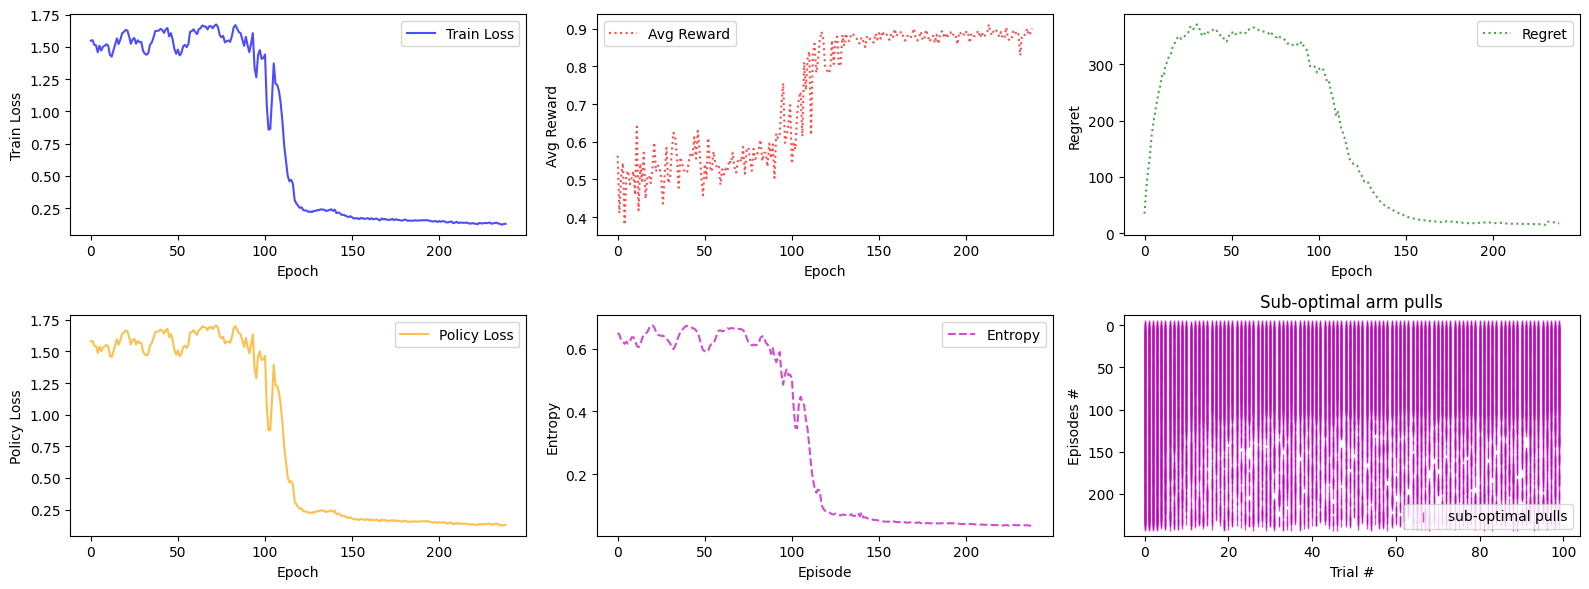

Episode 239/600 | Train Loss: 0.1334 | Avg Reward: 0.8820 | Cumulative Regret: 14.4000


In [ ]:
# ## Training Loop

results = {k: [] for k in ["avg_reward", "train_loss", "update", "regret"]}

# Initialize Plot
plt.ion()
# Control flags for using previous actions and rewards
if input_features == 1:
    use_prev_actions = False
    use_prev_rewards = False
else:
    use_prev_actions = True
    use_prev_rewards = True

# Training Loop

train_losses_plot, avg_reward_plot, regret_plot, num_suboptimal_pulls_plot, entropy_plot, policy_plot = [], [], [], [], [], []
policy_loss_plot, entropy_loss_plot, all_regret_plot = [], [], []

results = {k: [] for k in ["avg_reward", "train_loss", "update", "regret", "policy_loss", "entropy_loss", "all_regret"]}

# Initialize Plot
plt.ion()
# Control flags for using previous actions and rewards
if input_features == 1:
    use_prev_actions = False
    use_prev_rewards = False
else:
    use_prev_actions = True
    use_prev_rewards = True

all_regret_history = []
# Training Loop
for episode in range(num_episodes):
    train_losses, policy_losses, entropy_losses = [], [], []
    # Re-initialize Model and Train Distrib
    for bandit in bandits:
        bandit.reset()
    model.reset_hidden(batch_size=batch_size)
    
    model.train()
    model.reset_hidden(batch_size=batch_size)
    optimizer.zero_grad()

    log_probs = []
    rewards = []
    logitss = []

    prev_actions = None if not use_prev_actions else torch.zeros(batch_size, 2).to(device)
    prev_rewards = None if not use_prev_rewards else torch.zeros(batch_size, 1).to(device)
    
    for trial in range(num_trials_per_ep):
        timestep = torch.full((batch_size, 1), trial, dtype=torch.float32).to(device)

        input_components = [timestep]
        if use_prev_actions and prev_actions is not None:
            input_components.append(prev_actions)
        if use_prev_rewards and prev_rewards is not None:
            input_components.append(prev_rewards)

        inputs = torch.cat(input_components, dim=1)
        
        logits = model(inputs)
        actions, log_prob = select_action(logits)

        rewards_t = []
        new_actions = torch.zeros(batch_size, dtype=torch.long).to(device)
        for i, bandit in enumerate(bandits):
            reward, done, _ = bandit.pullArm(actions[i].item())
            rewards_t.append(reward)
            new_actions[i] = actions[i]
            if done:
                bandit.reset()
                
        if use_prev_actions:
            prev_actions = F.one_hot(new_actions, num_classes=2).float().to(device)
        if use_prev_rewards:
            prev_rewards = torch.tensor(rewards_t, dtype=torch.float32).unsqueeze(1).to(device)

        rewards.append(np.array(rewards_t))
        logitss.append(logits)
        log_probs.append(log_prob)
        
    # Compute Monte-Carlo returns
    returns = torch.zeros(batch_size, num_trials_per_ep).to(device)
    G = torch.zeros(batch_size).to(device)
    # Compute Policy Gradient Loss (cumulative across batch)
   
    rewards = torch.tensor(np.transpose(np.array(rewards), axes=[1,0]), dtype=torch.float32).to(device)
    # Compute Monte-Carlo returns
    loss = 0
    policy_loss_total = 0
    entropy_loss_total = 0
    entropy_coef = 0.05#anneal_entropy_coef(1., 0.0, episode, num_episodes)
    for t in reversed(range(num_trials_per_ep)):
        G = rewards[:, t] + discount * G
        returns[:, t] = G  # Discount factor (gamma=0.99)
        policy_loss = -(log_probs[t] * G).mean()
        policy_entropy = -torch.sum(F.softmax(logitss[t], dim=-1) * F.log_softmax(logitss[t], dim=-1), dim=-1).mean()
        policy_loss_total += policy_loss.item()
        entropy_loss_total += policy_entropy.item()
        
        loss += policy_loss - entropy_coef * policy_entropy
        
    # Compute loss using all episode losses
    loss /= num_trials_per_ep
    policy_loss_total /= num_trials_per_ep
    entropy_loss_total /= num_trials_per_ep
    
    # Backpropagation
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    train_losses.append(loss)
    policy_losses.append(policy_loss_total)
    entropy_losses.append(entropy_loss_total)
    
    if episode % test_interval == 0:
        # ## Evaluate Test Accuracy
        with torch.no_grad():  # Freeze RNN weights during testing
            model.eval()
            model.reset_hidden(batch_size=test_batch_size)
            # Test phase: evaluating performance on bandits drawn from test distribution
            test_bandits = [dependent_bandit(difficulty=bandit_difficulty) for _ in range(test_batch_size)]
            for bandit in test_bandits:
                bandit.reset()
            
            test_loss_total = 0
            outputs_test = []
            test_prev_actions = None if not use_prev_actions else torch.zeros(test_batch_size, 2).to(device)
            test_prev_rewards = None if not use_prev_rewards else torch.zeros(test_batch_size, 1).to(device)

            test_rewards = []
            test_exp_rewards = []
            for trial in range(test_num_trials):  # Unroll RNN for 100 trials
                timestep = torch.full((test_batch_size, 1), trial, dtype=torch.float32).to(device)

                input_components = [timestep]
                if use_prev_actions and test_prev_actions is not None:
                    input_components.append(test_prev_actions)
                if use_prev_rewards and test_prev_rewards is not None:
                    input_components.append(test_prev_rewards)
                inputs = torch.cat(input_components, dim=1)
                
                logits = model(inputs)
                actions, _ = select_action(logits)
                rewards_t = []
                exp_rewards_t = []
                test_new_actions = torch.zeros(test_batch_size, dtype=torch.long).to(device)
                for i, bandit in enumerate(test_bandits):
                    reward, _, _ = bandit.pullArm(actions[i].item())
                    rewards_t.append(reward)
                    test_new_actions[i] = actions[i]
                    exp_reward = bandit.bandit[actions[i]]
                    exp_rewards_t.append(exp_reward)
                test_rewards.append(np.array(rewards_t))
                test_exp_rewards.append(np.array(exp_rewards_t))
                if use_prev_actions:
                    test_prev_actions = F.one_hot(test_new_actions, num_classes=2).float().to(device)
                if use_prev_rewards:
                    test_prev_rewards = torch.tensor(rewards_t, dtype=torch.float32).unsqueeze(1).to(device)
            optimal_rewards = torch.tensor([[max(bandit.bandit) for _ in range(test_num_trials)] for bandit in test_bandits], dtype=torch.float32).to(device)
            test_rewards = torch.tensor(np.transpose(np.array(test_rewards), axes=[1, 0]), dtype=torch.float32).to(device)
            test_exp_rewards = torch.tensor(np.transpose(np.array(test_exp_rewards), axes=[1, 0]), dtype=torch.float32).to(device)
            regret = torch.sum(optimal_rewards - test_exp_rewards)
            all_regret = torch.mean(optimal_rewards - test_rewards, axis=0)
            # all_regret = torch.cumsum(all_regret, 0)
            # num_suboptimal_pulls = torch.sum(actions != torch.tensor([torch.argmax(b.bandit) for b in test_bandits], dtype=torch.long).to(device)).item()
            avg_reward = test_rewards.mean().item()
            train_loss_avg = np.mean(train_losses)
            policy_loss_avg = np.mean(policy_losses)
            entropy_loss_avg = np.mean(entropy_losses)
            print(f"Episode {episode}/{num_episodes} | Train Loss: {train_loss_avg:.4f} | Avg Reward: {avg_reward:.4f} | Cumulative Regret: {regret:.4f}")
            # f" | Suboptimal Pulls: {num_suboptimal_pulls}")

            # ## Update Loss Plots
            train_losses_plot.append(train_loss_avg)
            entropy_loss_plot.append(entropy_loss_avg)
            policy_loss_plot.append(policy_loss_avg)
            avg_reward_plot.append(avg_reward)
            regret_plot.append(regret)
            all_regret_plot.append(all_regret)
            # all_regret_history.append(all_regret_plot)
            # num_suboptimal_pulls_plot.append(num_suboptimal_pulls)
        
            results["update"].append(episode)
            results["train_loss"].append(train_loss_avg)
            results["policy_loss"].append(policy_loss_avg)
            results["entropy_loss"].append(entropy_loss_avg)
            results["avg_reward"].append(avg_reward)
            results["regret"].append(regret)
            results["all_regret"].append(all_regret)
            # results["num_suboptimal_pulls"].append(num_suboptimal_pulls)
        
            clear_output(wait=True)
            fig, axes = plt.subplots(2, 3, figsize=(16, 6), squeeze=False)
            # axes[1, 1].sharey(axes[1, 0])  # Share y-axis only in the second row
        
            # Train Loss Plot (Top Left)
            axes[0, 0].plot(train_losses_plot, ls="-", c="b", alpha=0.7, label="Train Loss")
            axes[0, 0].set_ylabel("Train Loss")
            axes[0, 0].set_xlabel("Epoch")
            axes[0, 0].legend()
            
            # Test Loss Plot (Top Right)
            avg_reward_plot_smmooth = exp_avg_convolve(avg_reward_plot, 0.1)
            axes[0, 1].plot(avg_reward_plot, ls=":", c="r", alpha=0.7, label="Avg Reward")
            axes[0, 1].set_ylabel("Avg Reward")
            axes[0, 1].set_xlabel("Epoch")
            axes[0, 1].legend()
    
            # Test Loss Plot (Top Right)
            regret_plot_smmooth = exp_avg_convolve(regret_plot, 0.1)
            axes[0, 2].plot(regret_plot_smmooth, ls=":", c="g", alpha=0.7, label="Regret")
            axes[0, 2].set_ylabel("Regret")
            axes[0, 2].set_xlabel("Epoch")
            axes[0, 2].legend()

            # Policy Loss Plot
            axes[1, 0].plot(policy_loss_plot, ls="-", c="orange", alpha=0.7, label="Policy Loss")
            axes[1, 0].set_ylabel("Policy Loss")
            axes[1, 0].set_xlabel("Epoch")
            axes[1, 0].legend()
            
            # Entropy Loss Plot
            axes[1, 1].plot(entropy_loss_plot, ls="--", c="m", alpha=0.7, label="Entropy")
            axes[1, 1].set_ylabel("Entropy")
            axes[1, 1].set_xlabel("Episode")
            axes[1, 1].legend()

            all_regret_history = np.stack(all_regret_plot)
            # axes[1, 2].plot(all_regret_plot, ls="--", c="m", alpha=0.7, label="all regret")
            # axes[1, 2].set_ylabel("all regret")
            # axes[1, 2].set_xlabel("Trials")
            # axes[1, 2].legend()
            # 1) find all the (eval, trial) pairs where regret > 0
            mask = all_regret_history > 0
            episodes, trials = np.nonzero(mask)

            # 2) clear the old line and draw ticks instead
            ax = axes[1, 2]
            ax.clear()

            ax.scatter(trials, episodes,
                    marker='|',         # vertical tick
                    c='m',              # match your magenta
                    alpha=0.7,
                    s=60,               # size of the tick
                    linewidths=1,
                    label='sub-optimal pulls')

            ax.set_title("Sub-optimal arm pulls")
            ax.set_xlabel("Trial #")
            ax.set_ylabel("Episodes #")
            ax.invert_yaxis()        # if you want eval 0 at the top
            ax.legend()

            # # Test Loss Plot (Top Right)
            # axes[1, 1].plot(num_suboptimal_pulls_plot, ls=":", c="r", alpha=0.7, label="Num Subopt Pulls")
            # axes[1, 1].set_ylabel("Num Subopt Pulls")
            # axes[1, 1].set_xlabel("Epoch")
            # axes[1, 1].legend()
            
            plt.tight_layout()
            plt.pause(0.1)


In [ ]:
# ## Save Model
params.get_exp_savepath().mkdir(parents=True, exist_ok=True)
if model_type == "colei":
    filestr = f"{params.get_exp_savepath()}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_{optimi}" 
    model_save_path_root = f"{PLAYGROUND_DIR}/saved_models/batch_size-{batch_size}/seed-{seed}"
    model_save_path = f"{model_save_path_root}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_{optimi}.pth"
else:
    filestr = f"{params.get_exp_savepath()}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_{optimi}" 
    model_save_path_root = f"{PLAYGROUND_DIR}/saved_models/batch_size-{batch_size}/seed-{seed}"
    model_save_path = f"{model_save_path_root}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_{optimi}.pth"
np.savez(filestr, **results)
print(f"Results saved at {filestr}.npz")
from pathlib import Path
model_save_path_root = Path(model_save_path_root)
model_save_path_root.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")
plt.ioff()
plt.show()